In [1]:
#pip install git+https://github.com/FacePerceiver/facer.git@main

In [11]:
import dlib
import cv2
import yaml
import numpy as np
from PIL import Image
from diff_exp.data.attribute_celeba_dataset import default_args, Dataset, _CELEBA_ATTRS
from omegaconf import OmegaConf
from diff_exp.transforms_utils import get_transform
import yaml
from tqdm import tqdm
from diff_exp.utils import TransformDataset, tensor2pil
from torchvision import transforms as tr
import torch as th
from einops import rearrange
from tqdm import trange, tqdm
from matplotlib import pyplot as plt

import sys
import torch
import facer
import os

In [46]:
args = default_args()
args = OmegaConf.create(args)

args.data_dir = "../data"
args.target_attr = "Young"

print(OmegaConf.to_yaml(args))
dataset = Dataset(**args)

target_attr: Young
data_dir: ../data
split: train
filter_path: null



In [47]:
crop = tr.CenterCrop(178)
resize = tr.Resize(64, antialias=True)

In [48]:
def transform(x):
    x = np.array(x)
    x = th.tensor(x)
    x = rearrange(x, "h w c -> c h w")
    return x

In [50]:
transformed_dataset = TransformDataset(dataset, transform)

In [51]:
len(transformed_dataset)

162770

In [52]:
loader = th.utils.data.DataLoader(transformed_dataset, batch_size=64, shuffle=False, drop_last=False)

In [53]:
device = "cuda:1"
face_detector = facer.face_detector("retinaface/mobilenet", device=device)
face_attr = facer.face_attr("farl/celeba/224", device=device)

In [ ]:
predicted_attributes = []
all_indices = []
all_labels = []
#    labels = face_attr.labels
idx_start = 0
for batch, y in tqdm(loader, desc="loading"):
    #x = x.to(device)
    batch = batch.to(device)
    indices = th.arange(idx_start, idx_start + len(batch))
    idx_start += len(batch)
    
    with torch.inference_mode():
        faces = face_detector(batch)

    with torch.inference_mode():
        faces = face_attr(batch, faces)


    face_attrs = faces["attrs"].cpu()
    indices = indices[faces["image_ids"].cpu()]
    y = y[faces["image_ids"].cpu()]
    
    predicted_attributes.append(face_attrs)
    all_indices.append(indices)
    all_labels.append(y)
    

In [ ]:
predicted_attributes = th.cat(predicted_attributes)
all_indices = th.cat(all_indices)
all_labels = th.cat(all_labels)

In [11]:
young_idx = _CELEBA_ATTRS.index("Young")

In [12]:
old_idxs = []
for idx, pred, label in zip(all_indices, predicted_attributes, all_labels):
    if pred[young_idx].item() < 0.1 and label.item() == 0:
        old_idxs.append(int(idx))

In [13]:
young_idxs = []
for idx, pred, label in zip(all_indices, predicted_attributes, all_labels):
    if pred[young_idx].item() > 0.9 and label.item() == 1:
        young_idxs.append(int(idx))

In [14]:
print("Young:", len(young_idxs))
print("Old:", len(old_idxs))

Young: 80908
Old: 15352


In [46]:
80908 / 96260

0.8405152711406607

In [298]:
old_and_young_idxs = old_idxs + young_idxs

In [299]:
old_and_young_idxs.sort()

In [302]:
with open("young_old_train.txt", "w") as f:
    line = "\n".join([str(x) for x in old_and_young_idxs])
    f.write(line)

In [270]:
len(old_and_young_idxs)

96270

In [173]:
smiling_idx = _CELEBA_ATTRS.index("Smiling")

In [210]:
kept_idxs = []
idx = 0
for img, attrs, label in zip(all_images, predicted_attributes, all_labels):
    if attrs[smiling_idx].item() > 0.9 and int(label) == 0:
        kept_idxs.append(idx)
    idx += 1

In [192]:
kept_idxs = []
idx = 0
for img, attrs, label in zip(all_images, predicted_attributes, all_labels):
    if attrs[smiling_idx].item() > 0.4 and attrs[smiling_idx] < 0.6:
        kept_idxs.append(idx)
    idx += 1

In [211]:
len(kept_idxs)

6334

In [18]:
for idx in range(0):
    idx = young_idxs[idx]
    img = dataset[idx][0]
    display(img)

## Filter according to evaluation classifier

In [29]:
import os
from diff_exp.utils import (
    mkdirs4file,
    TransformDataset,
    tensor2pil
)
import torch as th
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
import numpy as np
from tqdm import tqdm
from diff_exp.data.from_npz_dataset import NPZDataset
from torchvision import transforms as tr
from tqdm import tqdm
from diff_exp.transforms_utils import get_transform
import yaml
from PIL import Image

In [7]:
def pred_all(model, dataset, batch_size, device):
    loader = th.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=max(int(os.cpu_count() // 2), 1),
        shuffle=False,
    )

    model.eval()
    model = model.to(device)
    all_preds = []

    for batch in tqdm(loader, desc="Predict..."):
        x, y = batch
        x = x.to(device)
        with th.inference_mode():
            x = model(x)
        x = x.cpu()
        all_preds.append(x)
    all_preds = th.concat(all_preds, dim=0)
    return all_preds

In [236]:
from diff_exp.models.efficientnet import get_model, default_args
model_args = default_args()
model_args = OmegaConf.create(model_args)
print(model_args)
ckpt_path = "/home/anon/artifacts/test_classifiers/young_old_64x64_cls_calibrated.pt"

model = get_model(model_args)
ckpt = th.load(ckpt_path, map_location="cpu")
model.load_state_dict(ckpt['state_dict'])

{'size': 's', 'num_classes': 2}


<All keys matched successfully>

In [55]:
from diff_exp.data.attribute_celeba_dataset import default_args, Dataset 

In [237]:
args_yaml = """
target_attr: "Young"
data_dir: "../data"
split: "train"
filter_path: /home/anon/Documents/DiffusionExtrapolation-code/diff_exp/data/young_old_extreme_5_ensemble/train.txt

""".strip()
args = yaml.load(args_yaml, yaml.Loader)
args = OmegaConf.create(args)

In [238]:
transform_str = """
- - to_tensor
- - center_crop
  - size: 178
- - resize
  - size: 64
- - normalize
  - mean: 0.5, 0.5, 0.5
  - std: 0.5, 0.5, 0.5
""".strip()
transform = yaml.load(transform_str, yaml.Loader)
transform = OmegaConf.create(transform)
transform = get_transform(transform)

attribute_celeba = Dataset(**args)
attribute_celeba = TransformDataset(attribute_celeba, transform)

In [ ]:
in_slice_idx = [idx for idx, p in enumerate(celeba_preds[:, 1]) if float(p) < 0.1 or float(p) > 0.9]

In [67]:
eps = 0.1
sum(1 for x in celeba_preds if th.any(x < eps).item())

66504

In [239]:
device = "cuda:1"
celeba_preds = pred_all(model, attribute_celeba, 64, device)
celeba_preds = celeba_preds.softmax(-1)

Predict...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [00:03<00:00, 104.60it/s]


In [240]:
len(celeba_preds)

22000

In [242]:
len(attribute_celeba)

22000

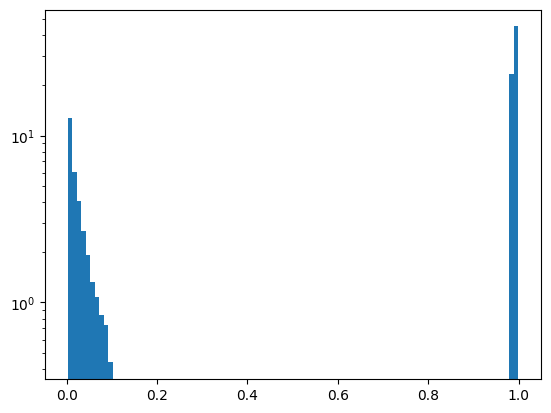

In [241]:
# All of CelebA
plt.hist(celeba_preds[:, 1], bins=100, density=True)
plt.yscale("log")
plt.show()


In [31]:
original_idxs = attribute_celeba.dataset.idxs
kept_idxs = [idx for idx, x in enumerate(celeba_preds[:, 1]) if float(x) < 0.2 or float(x) > 0.8]
kept_idxs_in_celeba = [original_idxs[idx] for idx in kept_idxs]


TypeError: 'NoneType' object is not subscriptable

In [40]:
len(kept_idxs)

48542

In [41]:
# Count kept young + old
n_old = 0
n_young = 0
for idx in tqdm(kept_idxs):
    x, y = attribute_celeba[idx]
    if int(y) == 1:
        n_young += 1
    else:
        n_old += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 48542/48542 [00:27<00:00, 1774.07it/s]


In [43]:
print("Old:", n_old)
print("Young:", n_young)

Old: 18473
Young: 30069


In [44]:
with open("young_old_train_filtered_extreme.txt", "w") as f:
    line = "\n".join((str(x) for x in kept_idxs_in_celeba))
    f.write(line)

## Check samples kept by the ensemble

In [98]:
ensemble_run_ids = [
    "lds91su0",
    "3zvzd018",
    "ub3lacvc",
    "wp38sa3h",
    "k2ipi84k",
]

In [99]:
import os.path as osp

In [200]:
args_yaml = """
target_attr: "Young"
data_dir: "../data"
split: "train"
filter_path: ../data/young_old_extreme/train.txt
""".strip()
args = yaml.load(args_yaml, yaml.Loader)
args = OmegaConf.create(args)

In [201]:
transform_str = """
- - to_tensor
- - center_crop
  - size: 178
- - resize
  - size: 64
- - normalize
  - mean: 0.5, 0.5, 0.5
  - std: 0.5, 0.5, 0.5
""".strip()
transform = yaml.load(transform_str, yaml.Loader)
transform = OmegaConf.create(transform)
transform = get_transform(transform)

attribute_celeba = Dataset(**args)
attribute_celeba = TransformDataset(attribute_celeba, transform)

In [202]:
prefix_path = "/home/anon/Documents/DiffusionExtrapolation-code/diff_exp/young_filter_ensemble"

paths = [osp.join(prefix_path, run_id, "checkpoints", "best.pt") for run_id in ensemble_run_ids]
paths += ["/home/anon/artifacts/test_classifiers/young_old_64x64_cls_calibrated.pt"]
ckpts = [th.load(p, map_location="cpu")['state_dict'] for p in paths]

all_preds = []

for ckpt in ckpts:
    model.load_state_dict(ckpt)
    out = pred_all(model, attribute_celeba, 64, "cuda:1").softmax(-1)
    all_preds.append(out)

Predict...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1505/1505 [00:13<00:00, 111.56it/s]


In [205]:
preds_stack = th.stack(all_preds)

In [226]:
eps = 0.1
preds_mask = preds_stack < eps
preds_mask = th.any(preds_mask, dim=-1)
preds_mask = th.all(preds_mask, dim=0)

In [228]:
dataset_labels = [int(y) for x, y in attribute_celeba]

In [227]:
kept_idxs = [idx for idx, v in enumerate(preds_mask) if bool(v)]
len(kept_idxs)

43275

In [230]:
kept_labels = [dataset_labels[idx] for idx in kept_idxs]

IndexError: list index out of range

In [ ]:
sum(1 for label in kept_labels if label == 0)

In [197]:
len(kept_labels)

26085

In [147]:
kept_idxs.sort()

In [209]:
to_write_idxs = [attribute_celeba.dataset.idxs[idx] for idx in kept_idxs]

In [210]:
with open("young_old_extreme_ensemble.txt", "w") as f:
    line = "\n".join(str(x) for x in to_write_idxs)
    f.write(line)

In [231]:
args_yaml = """
target_attr: "Young"
data_dir: "../data"
split: "train"
filter_path: ../data/young_old_extreme_ensemble.txt
""".strip()
args = yaml.load(args_yaml, yaml.Loader)
args = OmegaConf.create(args)

In [232]:
transform_str = """
- - to_tensor
- - center_crop
  - size: 178
- - resize
  - size: 64
- - normalize
  - mean: 0.5, 0.5, 0.5
  - std: 0.5, 0.5, 0.5
""".strip()
transform = yaml.load(transform_str, yaml.Loader)
transform = OmegaConf.create(transform)
transform = get_transform(transform)

attribute_celeba = Dataset(**args)
attribute_celeba = TransformDataset(attribute_celeba, transform)

In [233]:
eval_ckpt_path = "/home/anon/artifacts/test_classifiers/young_old_64x64_cls_calibrated.pt"
eval_ckpt = th.load(eval_ckpt_path)['state_dict']
model.load_state_dict(eval_ckpt)

<All keys matched successfully>

In [234]:
extreme_preds = pred_all(model, attribute_celeba, 64, "cuda:1")

Predict...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:06<00:00, 108.78it/s]


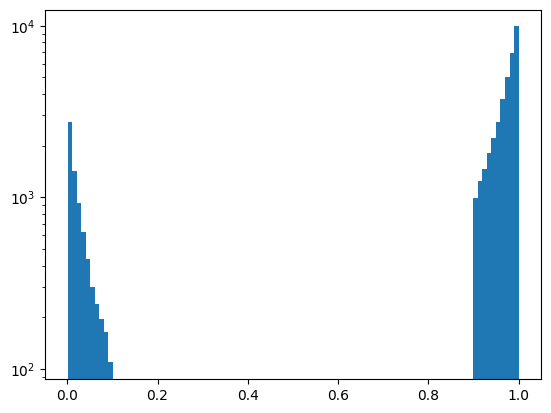

In [235]:
plt.hist(extreme_preds.softmax(-1)[:, 1], bins=100)
plt.yscale("log")
plt.show()

In [216]:
old_idxs = []
young_idxs = []
for idx, (x, y) in enumerate(tqdm(attribute_celeba)):
    if int(y) == 0:
        old_idxs.append(idx)
    else:
        young_idxs.append(idx)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 58731/58731 [00:33<00:00, 1761.11it/s]


In [220]:
from diff_exp.utils import tensor2pil

1


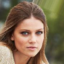

1


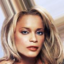

1


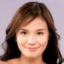

1


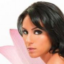

1


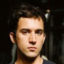

1


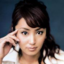

1


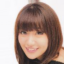

1


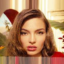

1


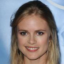

1


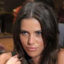

1


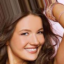

1


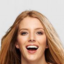

1


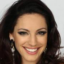

1


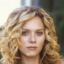

1


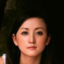

1


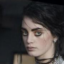

1


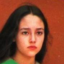

1


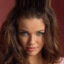

1


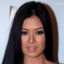

1


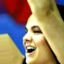

1


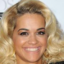

1


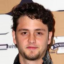

1


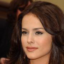

1


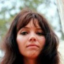

1


1


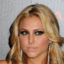

1


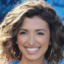

1


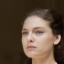

1


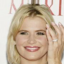

1


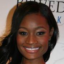

1


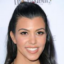

1


1


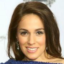

1


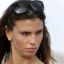

1


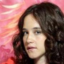

1


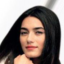

1


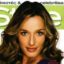

1


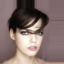

1


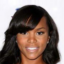

1


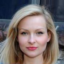

1


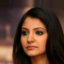

1


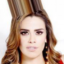

1


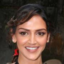

1


1


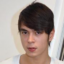

1


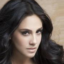

1


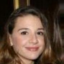

1


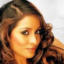

1


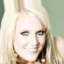

1


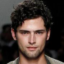

1


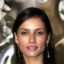

1


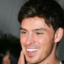

1


1


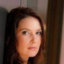

1


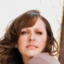

1


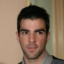

1


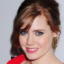

1


1


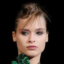

1


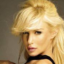

1


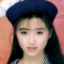

1


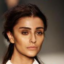

1


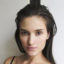

1


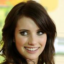

1


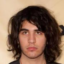

1


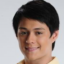

1


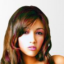

1


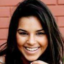

1


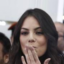

1


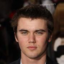

1


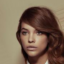

1


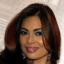

1


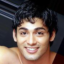

1


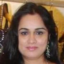

1


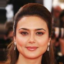

1


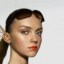

1


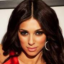

1


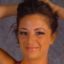

1


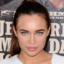

1


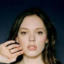

1


1


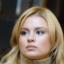

1


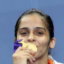

1


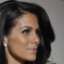

1


1


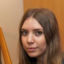

1


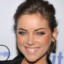

1


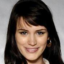

1


1


1


1


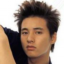

1


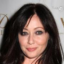

1


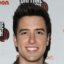

1


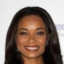

1


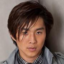

1


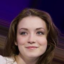

1


1


1


In [225]:
def display_old():
    for _ in range(100):
        idx = random.randint(0, len(old_idxs) - 1)
        idx = old_idxs[idx]
        img, idx = attribute_celeba[idx]
        img = (img + 1) / 2
        display(tensor2pil(img))
        print(idx.item())
        
def display_young():
    for _ in range(100):
        idx = random.randint(0, len(young_idxs) - 1)
        idx = young_idxs[idx]
        img, idx = attribute_celeba[idx]
        img = (img + 1) / 2
        display(tensor2pil(img))
        print(idx.item())


#display_young()
    